# Actividad :  Resolución de problema mediante búsqueda heurística





## Importante

El código siguiente es el que debe usarse para la ejecución de la actividad.
En caso de requerir modificaciones se subirán ficheros de sustitución al aula de la asignatura


In [114]:
!pip install simpleai flask pydot graphviz
import matplotlib.pyplot as plt
import networkx as nx

In [115]:
#!/usr/bin/env python
# coding: utf-8

# 2024 Modified by: Alejandro Cervantes
# Remember installing pyplot and flask if you want to use WebViewer

# NOTA: WebViewer sólo funcionará si ejecutáis en modo local

from __future__ import print_function

import math
from simpleai.search.viewers import BaseViewer,ConsoleViewer,WebViewer
from simpleai.search import SearchProblem, astar, breadth_first, depth_first, uniform_cost

node_count = 0
nodes = []
edges = []
depth_count = 1
label_with_heuristic_number = False

class Node():
    
    def __init__(self,
                 node_count,
                 father_node_point,
                 point_x, point_y,
                 depht,
                 action,
                 heuristic_number,
                 acumulated_cost = 0):
        self.node_count = node_count
        self.father_node_point = father_node_point
        self.point = (point_x, point_y)
        self.depht = depht
        self.action = action
        self.heuristic_number = heuristic_number
        self.acumulated_cost = acumulated_cost
        if (self.point == (3, 3)):
            self.identifier = "T"
        elif (self.point == (5, 1)):
            self.identifier = "P"
        else:
            self.identifier = f"n{node_count}_d{depht}_{self.point}_{action}"

class GameWalkPuzzle(SearchProblem):

    def __init__(self, board, costs, heuristic_number):
        global node_count, nodes  
        self.board = board
        self.goal = (0, 0)
        self.costs = costs
        self.heuristic_number = heuristic_number
        for y in range(len(self.board)):
            for x in range(len(self.board[y])):
                if self.board[y][x].lower() == "t":
                    self.initial = (x, y)
                    node_count += 1
                    node = Node(  
                      node_count=node_count,
                      father_node_point=(3, 3),
                      point_x=x,
                      point_y=y,
                      depht=0,
                      action="no action",
                      heuristic_number=heuristic_number
                    )
                    nodes.append(node)
                elif self.board[y][x].lower() == "p":
                    self.goal = (x, y)

        super(GameWalkPuzzle, self).__init__(initial_state=self.initial)

    def actions(self, state):
        global node_count, nodes, depth_count, edges, label_with_heuristic_number
        x, y = state
        actions = []
        for action in list(self.costs.keys()):
            newx, newy = self.result(state, action)
            if self.board[newy][newx] != "#":
                node_count = node_count + 1
                actions.append(action)
                new_node = Node(
                    node_count=node_count,
                    father_node_point=(x, y),
                    point_x=newx,
                    point_y=newy,
                    depht=depth_count,
                    action=action,
                    heuristic_number=self.heuristic_number
                )
                node_father = [n for n in nodes if n.point == (x, y)][0]
                fatthers = [n for n in nodes if n.point == (x, y)]
                for n in fatthers:
                    print(f"i:{n.identifier} ac:{n.acumulated_cost}")
                father_cost = node_father.acumulated_cost
                movement_cost_integer = int(self.costs[action])
                total_cost_node = father_cost + movement_cost_integer
                new_node.acumulated_cost = total_cost_node
                print(f"New node {new_node.identifier} ac -> {total_cost_node}")
                if label_with_heuristic_number:
                    heuristic_cost = self.heuristic((x, y))
                    edges.append((
                        node_father.identifier,
                        new_node.identifier,
                        {"cost": f"c:{father_cost}h:{heuristic_cost}s:{father_cost + heuristic_cost}"}
                        ))
                else:  
                    edges.append((node_father.identifier, new_node.identifier, {"cost": f"c:{father_cost}"}))
                nodes.append(new_node)
                
        depth_count = depth_count + 1
        return actions

    def result(self, state, action):
        x, y = state

        if action.count("up"):
            y -= 1
        if action.count("down"):
            y += 1
        if action.count("left"):
            x -= 1
        if action.count("right"):
            x += 1

        new_state = (x, y)
        return new_state

    def is_goal(self, state):
        return state == self.goal

    def cost(self, state, action, state2):
        return self.costs[action]

    # Esta función heurística es la distancia entre el estado actual
    # el objetivo (único) identificado como self.goal
    def heuristic1(self, state):
        x, y = state
        gx, gy = self.goal
        result = abs(x - gx) + abs(y - gy)
        # print(f"P:{x, y}, H:({result})")
        return result

    def heuristic2(self, state):
        x, y = state
        gx, gy = self.goal
        result = max(abs(x - gx),abs(y - gy))
        # print(f"P:{x, y}, H:({result})")
        return result

    def heuristic3(self, state):
        x, y = state
        gx, gy = self.goal
        result = 2*(abs(x - gx) + abs(y - gy))
        # print(f"P:{x, y}, H:({result})")
        return result

    def heuristic(self,state):
      if self.heuristic_number == 1:
          return self.heuristic1(state)
      elif self.heuristic_number == 2:
          return self.heuristic2(state)
      elif self.heuristic_number == 3:
          return self.heuristic3(state)
      else:
        raise Exception("El número de la función heurística debe estar entre 1 y 3. Revise la inicialización del problema.")

def searchInfo (problem,result,use_viewer):
    def getTotalCost (problem,result):
        originState = problem.initial_state
        totalCost = 0
        for action,endingState in result.path():
            if action is not None:
                totalCost += problem.cost(originState,action,endingState)
                originState = endingState
        return totalCost


    res = "Total length of solution: {0}\n".format(len(result.path()))
    res += "Total cost of solution: {0}\n".format(getTotalCost(problem,result))

    if use_viewer:
        stats = [{'name': stat.replace('_', ' '), 'value': value}
                         for stat, value in list(use_viewer.stats.items())]

        for s in stats:
            res+= '{0}: {1}\n'.format(s['name'],s['value'])
    return res


def resultado_experimento(problem,MAP,result,used_viewer):
    path = [x[1] for x in result.path()]

    for y in range(len(MAP)):
        for x in range(len(MAP[y])):
            if (x, y) == problem.initial:
                print("T", end='')
            elif (x, y) == problem.goal:
                print("P", end='')
            elif (x, y) in path:
                print("·", end='')
            else:
                print(MAP[y][x], end='')
        print()

    info = searchInfo(problem, result, used_viewer)
    print(info)

def main(MAP_ASCII,COSTS,algorithms,heuristic_number=1):
    MAP = [list(x) for x in MAP_ASCII.split("\n") if x]
    node_count = 0

    for algorithm in algorithms:
      problem = GameWalkPuzzle(MAP,COSTS,heuristic_number)
      used_viewer=BaseViewer()
      # Probad también ConsoleViewer para depurar
      # No podréis usar WebViewer en Collab para ver los árboles

      # Mostramos tres experimentos
      print ("Experimento con algoritmo {}:".format(algorithm))

      result = algorithm(problem, graph_search=True,viewer=used_viewer)
      resultado_experimento(problem,MAP,result,used_viewer)

## Busqueda en profundidad y anchura con mismo coste

Experimento con algoritmo <function breadth_first at 0x000001D4AA0FC7C0>:
i:T ac:0
New node n2_d1_(4, 3)_right ac -> 1
i:T ac:0
New node n3_d1_(2, 3)_left ac -> 1
i:n2_d1_(4, 3)_right ac:1
New node n4_d2_(4, 4)_down ac -> 2
i:n2_d1_(4, 3)_right ac:1
New node T ac -> 2
i:n3_d1_(2, 3)_left ac:1
New node T ac -> 2
i:n3_d1_(2, 3)_left ac:1
New node n7_d3_(1, 3)_left ac -> 2
i:n4_d2_(4, 4)_down ac:2
New node n8_d4_(4, 3)_up ac -> 3
i:n4_d2_(4, 4)_down ac:2
New node n9_d4_(4, 5)_down ac -> 3
i:n4_d2_(4, 4)_down ac:2
New node n10_d4_(5, 4)_right ac -> 3
i:n7_d3_(1, 3)_left ac:2
New node n11_d5_(1, 2)_up ac -> 3
i:n7_d3_(1, 3)_left ac:2
New node n12_d5_(1, 4)_down ac -> 3
i:n7_d3_(1, 3)_left ac:2
New node n13_d5_(2, 3)_right ac -> 3
i:n9_d4_(4, 5)_down ac:3
New node n14_d6_(4, 4)_up ac -> 4
i:n9_d4_(4, 5)_down ac:3
New node n15_d6_(5, 5)_right ac -> 4
i:n9_d4_(4, 5)_down ac:3
New node n16_d6_(3, 5)_left ac -> 4
i:n10_d4_(5, 4)_right ac:3
New node n17_d7_(5, 5)_down ac -> 4
i:n10_d4_(5, 4)_righ

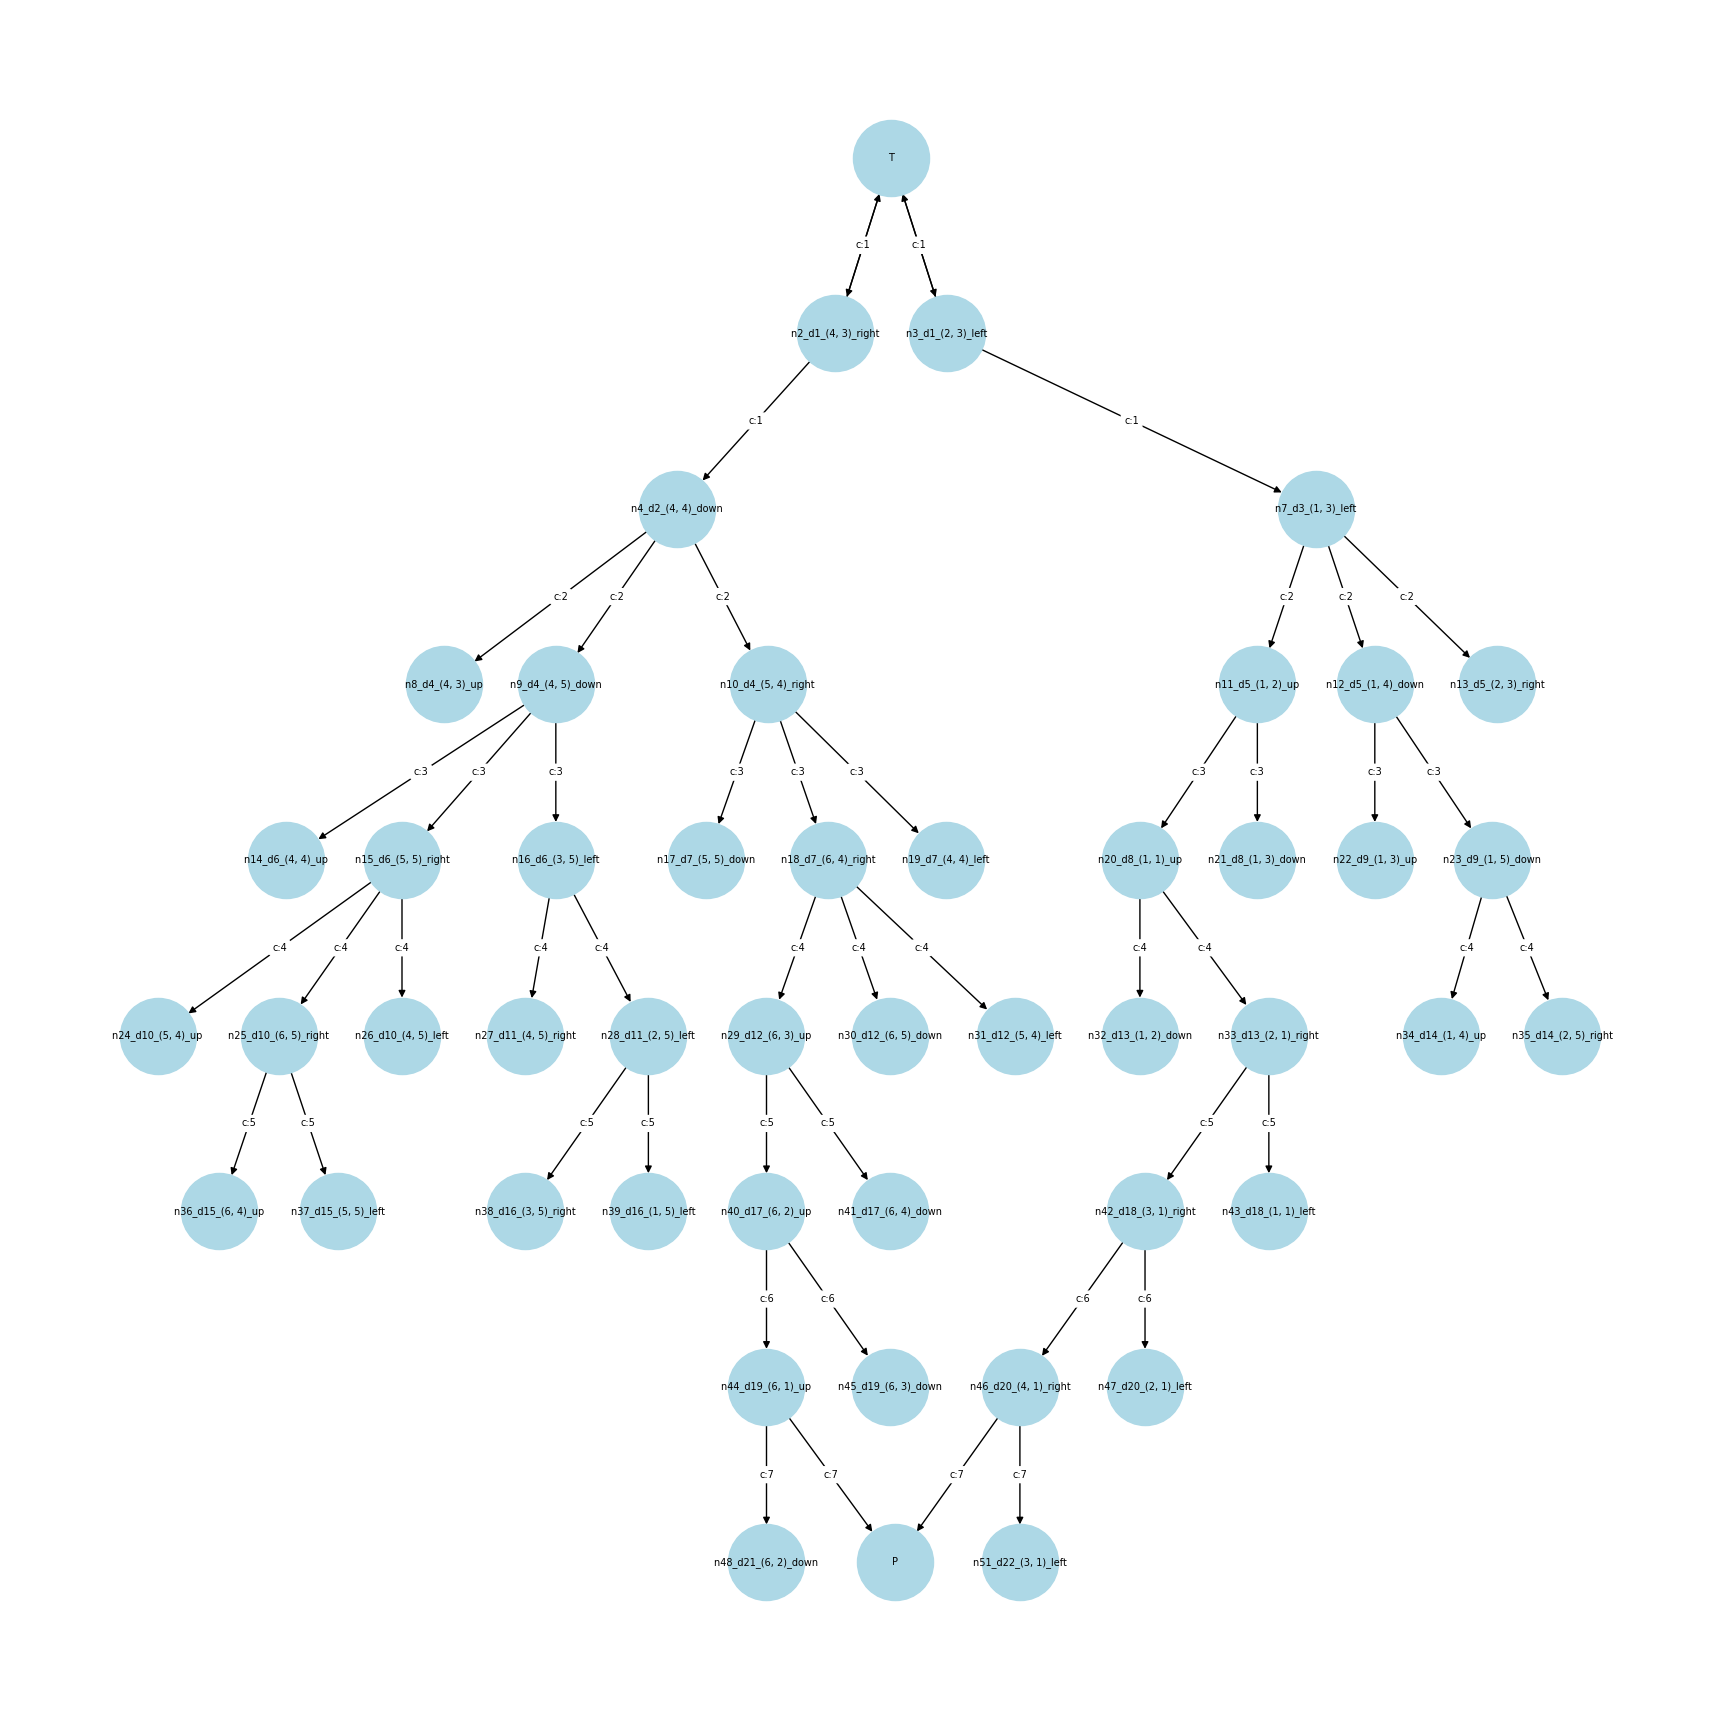

In [116]:
#!/usr/bin/env python
# coding: utf-8

# 2024 Modified by: Alejandro Cervantes
# Configuración y llamada para el caso 1
# Se ejecutan los algoritmos de búsqueda en amplitud y búsqueda en profundidad

MAP_ASCII = """
########
#    P #
# #### #
#  T # #
# ##   #
#      #
########
"""

COSTS = {
    "up": 1.0,
    "down": 1.0,
    "right": 1.0,
    "left": 1.0,
}

node_count = 0
nodes = []
edges = []
depth_count = 1

# algorithms=(breadth_first, depth_first)
algorithms=(breadth_first,)
main (MAP_ASCII, COSTS, algorithms)

print(len(edges))
unique_y = {tup[1] for tup in edges}
print(len(unique_y))

for edge in edges:
    print(edge)

# Crear un grafo tipo árbol
G = nx.DiGraph()

G.add_edges_from(edges)

# Dibujar el grafo con un diseño jerárquico
pos = nx.nx_agraph.graphviz_layout(G, prog="dot")  # Necesita Graphviz instalado
plt.figure(figsize=(17, 17))
nx.draw(G, pos, with_labels=True, arrows=True, node_size=3000, node_color="lightblue", font_size=7)

# Get edge labels and draw them
edge_labels = nx.get_edge_attributes(G, "cost")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, rotate=False)

# Mostrar el árbol
plt.show()

Experimento con algoritmo <function depth_first at 0x000001D4AA0FDBC0>:
i:T ac:0
New node n2_d1_(4, 3)_right ac -> 1
i:T ac:0
New node n3_d1_(2, 3)_left ac -> 1
i:n3_d1_(2, 3)_left ac:1
New node T ac -> 2
i:n3_d1_(2, 3)_left ac:1
New node n5_d2_(1, 3)_left ac -> 2
i:n5_d2_(1, 3)_left ac:2
New node n6_d3_(1, 2)_up ac -> 3
i:n5_d2_(1, 3)_left ac:2
New node n7_d3_(1, 4)_down ac -> 3
i:n5_d2_(1, 3)_left ac:2
New node n8_d3_(2, 3)_right ac -> 3
i:n7_d3_(1, 4)_down ac:3
New node n9_d4_(1, 3)_up ac -> 4
i:n7_d3_(1, 4)_down ac:3
New node n10_d4_(1, 5)_down ac -> 4
i:n10_d4_(1, 5)_down ac:4
New node n11_d5_(1, 4)_up ac -> 5
i:n10_d4_(1, 5)_down ac:4
New node n12_d5_(2, 5)_right ac -> 5
i:n12_d5_(2, 5)_right ac:5
New node n13_d6_(3, 5)_right ac -> 6
i:n12_d5_(2, 5)_right ac:5
New node n14_d6_(1, 5)_left ac -> 6
i:n13_d6_(3, 5)_right ac:6
New node n15_d7_(4, 5)_right ac -> 7
i:n13_d6_(3, 5)_right ac:6
New node n16_d7_(2, 5)_left ac -> 7
i:n15_d7_(4, 5)_right ac:7
New node n17_d8_(4, 4)_up ac -> 8

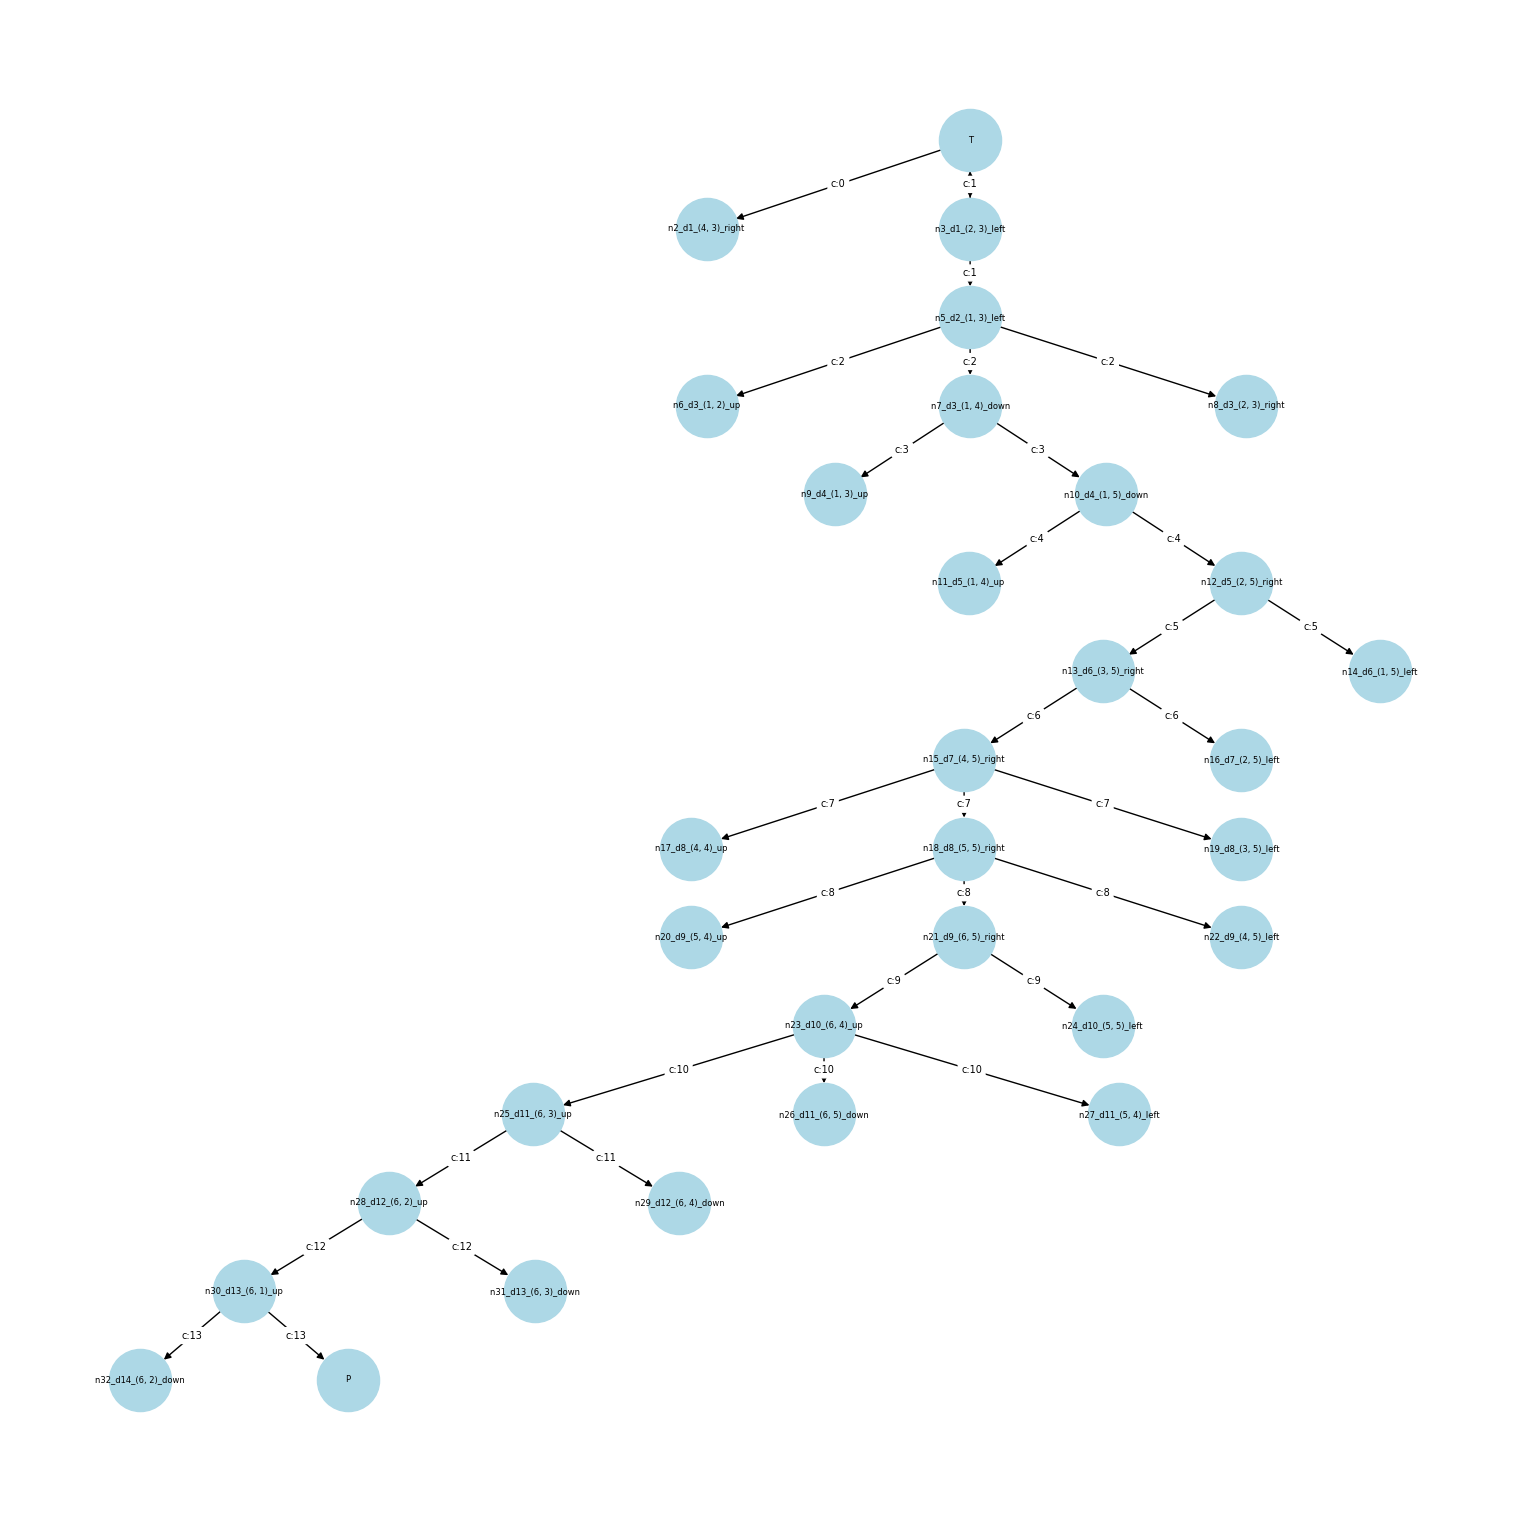

In [117]:
#!/usr/bin/env python
# coding: utf-8

# 2024 Modified by: Alejandro Cervantes
# Configuración y llamada para el caso 1
# Se ejecutan los algoritmos de búsqueda en amplitud y búsqueda en profundidad

MAP_ASCII = """
########
#    P #
# #### #
#  T # #
# ##   #
#      #
########
"""

node_count = 0
nodes = []
edges = []
depth_count = 1
label_with_heuristic_number = False


COSTS = {
    "up": 1.0,
    "down": 1.0,
    "right": 1.0,
    "left": 1.0,
}

algorithms=(depth_first,)
main (MAP_ASCII, COSTS, algorithms)

# Crear un grafo tipo árbol
G = nx.DiGraph()

G.add_edges_from(edges)

# for edge in edges:
#     print(edge)

# Dibujar el grafo con un diseño jerárquico
pos = nx.nx_agraph.graphviz_layout(G, prog="dot")  # Necesita Graphviz instalado
plt.figure(figsize=(15, 15))
nx.draw(G, pos, with_labels=True, arrows=True, node_size=2000, node_color="lightblue", font_size=6)

# Get edge labels and draw them
edge_labels = nx.get_edge_attributes(G, "cost")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, rotate=False)

# Mostrar el árbol
plt.show()

## Busqueda en anchura, coste uniforme y A* con coste diferente

Experimento con algoritmo <function breadth_first at 0x000001D4AA0FC7C0>:
i:T ac:0
New node n2_d1_(4, 3)_right ac -> 2
i:T ac:0
New node n3_d1_(2, 3)_left ac -> 2
i:n2_d1_(4, 3)_right ac:2
New node n4_d2_(4, 4)_down ac -> 7
i:n2_d1_(4, 3)_right ac:2
New node T ac -> 4
i:n3_d1_(2, 3)_left ac:2
New node T ac -> 4
i:n3_d1_(2, 3)_left ac:2
New node n7_d3_(1, 3)_left ac -> 4
i:n4_d2_(4, 4)_down ac:7
New node n8_d4_(4, 3)_up ac -> 12
i:n4_d2_(4, 4)_down ac:7
New node n9_d4_(4, 5)_down ac -> 12
i:n4_d2_(4, 4)_down ac:7
New node n10_d4_(5, 4)_right ac -> 9
i:n7_d3_(1, 3)_left ac:4
New node n11_d5_(1, 2)_up ac -> 9
i:n7_d3_(1, 3)_left ac:4
New node n12_d5_(1, 4)_down ac -> 9
i:n7_d3_(1, 3)_left ac:4
New node n13_d5_(2, 3)_right ac -> 6
i:n9_d4_(4, 5)_down ac:12
New node n14_d6_(4, 4)_up ac -> 17
i:n9_d4_(4, 5)_down ac:12
New node n15_d6_(5, 5)_right ac -> 14
i:n9_d4_(4, 5)_down ac:12
New node n16_d6_(3, 5)_left ac -> 14
i:n10_d4_(5, 4)_right ac:9
New node n17_d7_(5, 5)_down ac -> 14
i:n10_d4_(5

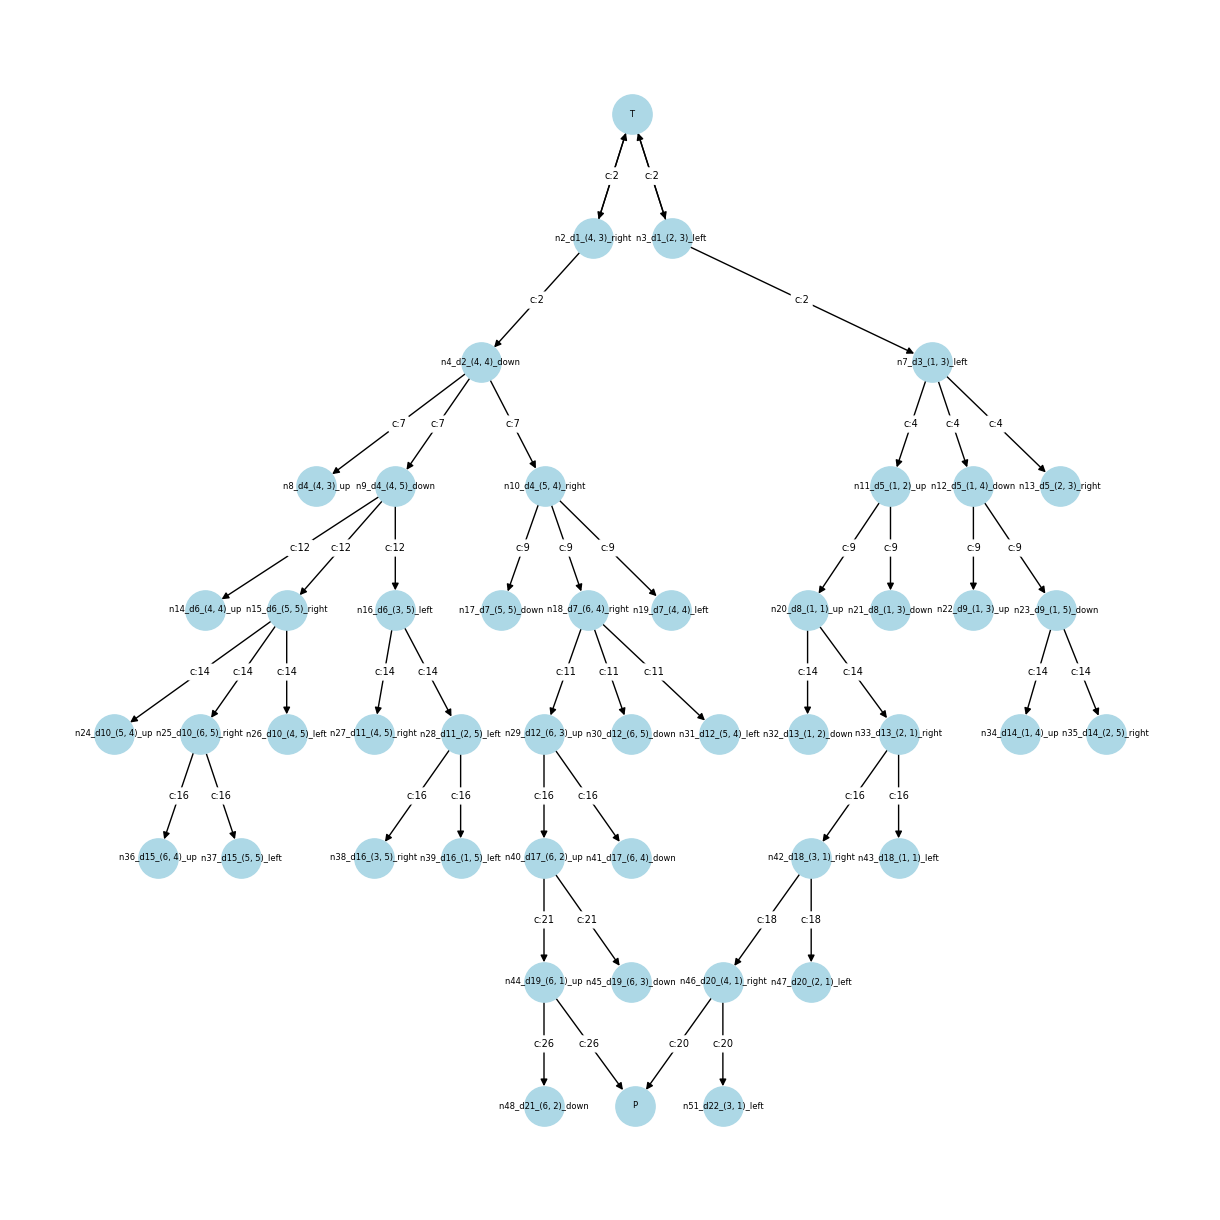

In [118]:
#!/usr/bin/env python
# coding: utf-8

# 2024 Modified by: Alejandro Cervantes
# Configuración y llamada para el caso 2
# Se utiliza el mismo mapa pero se varían los costes

MAP_ASCII = """
########
#    P #
# #### #
#  T # #
# ##   #
#      #
########
"""

COSTS = {
    "up": 5.0,
    "down": 5.0,
    "right": 2.0,
    "left": 2.0,
}

node_count = 0
nodes = []
edges = []
depth_count = 1

algorithms=(breadth_first,)
main (MAP_ASCII, COSTS, algorithms)

# Crear un grafo tipo árbol
G = nx.DiGraph()

G.add_edges_from(edges)

# for edge in edges:
#     print(edge)

# Dibujar el grafo con un diseño jerárquico
pos = nx.nx_agraph.graphviz_layout(G, prog="dot")  # Necesita Graphviz instalado
plt.figure(figsize=(12, 12))
nx.draw(G, pos, with_labels=True, arrows=True, node_size=800, node_color="lightblue", font_size=6)

# Get edge labels and draw them
edge_labels = nx.get_edge_attributes(G, "cost")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, rotate=False)

# Mostrar el árbol
plt.show()

Experimento con algoritmo <function uniform_cost at 0x000001D4AA0FEAC0>:
i:T ac:0
New node n2_d1_(4, 3)_right ac -> 2
i:T ac:0
New node n3_d1_(2, 3)_left ac -> 2
i:n2_d1_(4, 3)_right ac:2
New node n4_d2_(4, 4)_down ac -> 7
i:n2_d1_(4, 3)_right ac:2
New node T ac -> 4
i:n3_d1_(2, 3)_left ac:2
New node T ac -> 4
i:n3_d1_(2, 3)_left ac:2
New node n7_d3_(1, 3)_left ac -> 4
i:n7_d3_(1, 3)_left ac:4
New node n8_d4_(1, 2)_up ac -> 9
i:n7_d3_(1, 3)_left ac:4
New node n9_d4_(1, 4)_down ac -> 9
i:n7_d3_(1, 3)_left ac:4
New node n10_d4_(2, 3)_right ac -> 6
i:n4_d2_(4, 4)_down ac:7
New node n11_d5_(4, 3)_up ac -> 12
i:n4_d2_(4, 4)_down ac:7
New node n12_d5_(4, 5)_down ac -> 12
i:n4_d2_(4, 4)_down ac:7
New node n13_d5_(5, 4)_right ac -> 9
i:n8_d4_(1, 2)_up ac:9
New node n14_d6_(1, 1)_up ac -> 14
i:n8_d4_(1, 2)_up ac:9
New node n15_d6_(1, 3)_down ac -> 14
i:n9_d4_(1, 4)_down ac:9
New node n16_d7_(1, 3)_up ac -> 14
i:n9_d4_(1, 4)_down ac:9
New node n17_d7_(1, 5)_down ac -> 14
i:n13_d5_(5, 4)_right ac

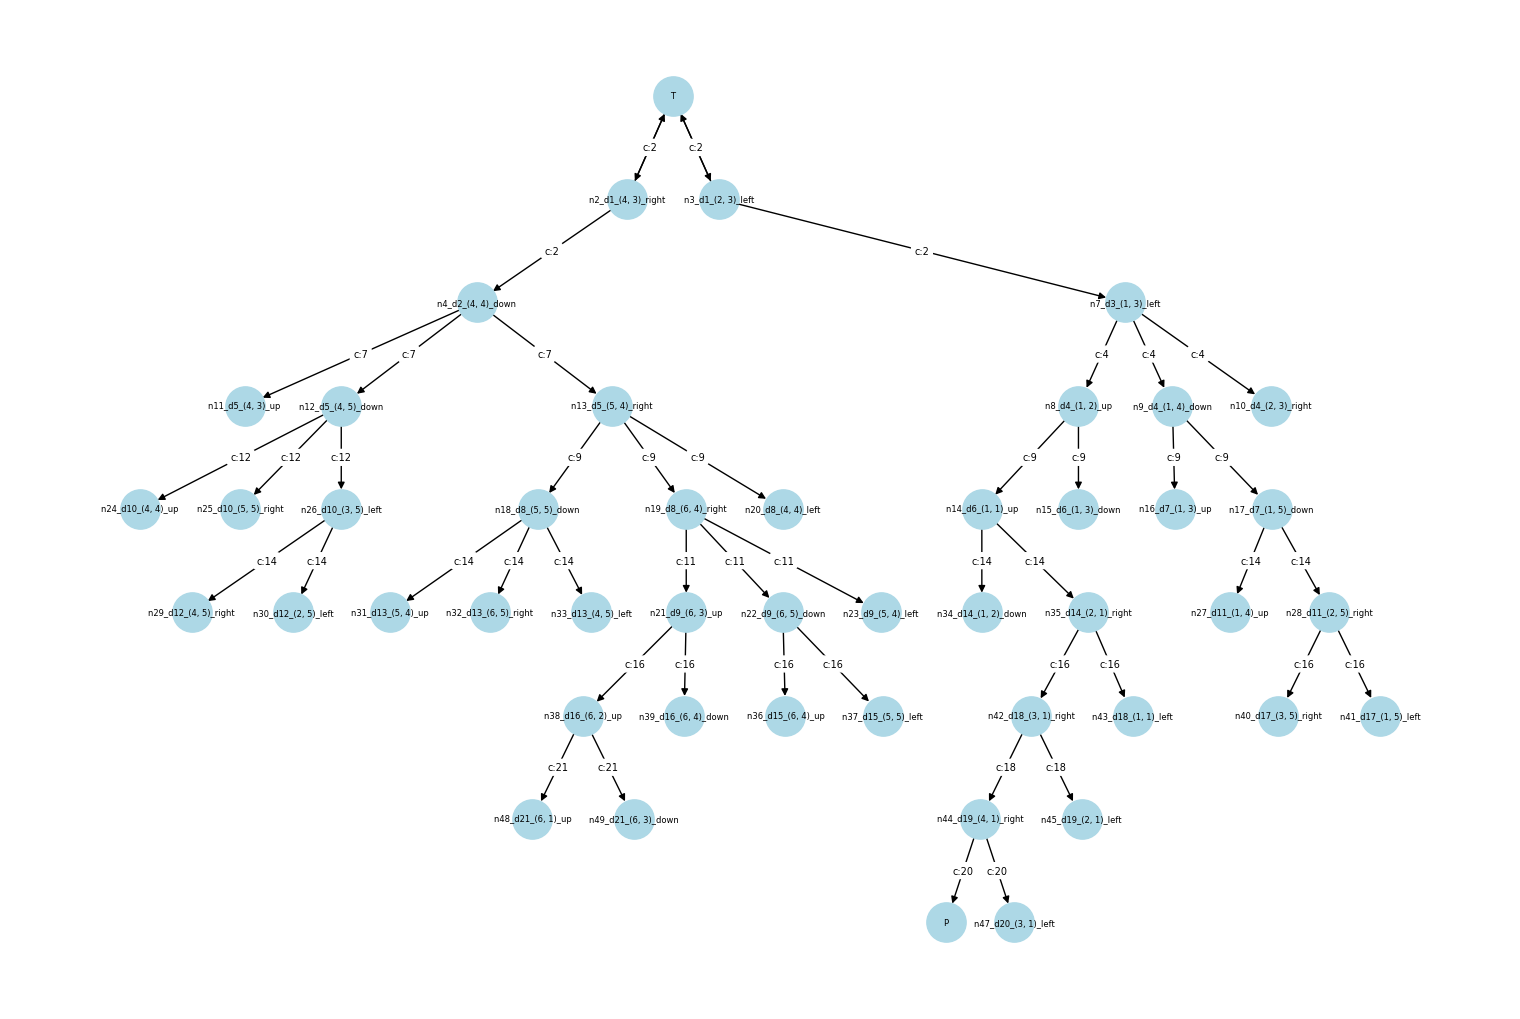

In [119]:
#!/usr/bin/env python
# coding: utf-8

# 2024 Modified by: Alejandro Cervantes
# Configuración y llamada para el caso 2
# Se utiliza el mismo mapa pero se varían los costes

MAP_ASCII = """
########
#    P #
# #### #
#  T # #
# ##   #
#      #
########
"""

COSTS = {
    "up": 5.0,
    "down": 5.0,
    "right": 2.0,
    "left": 2.0,
}
'''
COSTS = {
    "up": 1.0,
    "down": 1.0,
    "right": 1.0,
    "left": 1.0,
}
'''

node_count = 0
nodes = []
edges = []
depth_count = 1
label_with_heuristic_number = False

algorithms=(uniform_cost,)
main (MAP_ASCII, COSTS, algorithms)

# Crear un grafo tipo árbol
G = nx.DiGraph()

G.add_edges_from(edges)

# for edge in edges:
#     print(edge)

# Dibujar el grafo con un diseño jerárquico
pos = nx.nx_agraph.graphviz_layout(G, prog="dot")  # Necesita Graphviz instalado
plt.figure(figsize=(15, 10))
nx.draw(G, pos, with_labels=True, arrows=True, node_size=800, node_color="lightblue", font_size=6)

# Get edge labels and draw them
edge_labels = nx.get_edge_attributes(G, "cost")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, rotate=False)

# Mostrar el árbol
plt.show()

Experimento con algoritmo <function astar at 0x000001D4AA0FEC00>:
i:T ac:0
New node n2_d1_(4, 3)_right ac -> 2
i:T ac:0
New node n3_d1_(2, 3)_left ac -> 2
i:n2_d1_(4, 3)_right ac:2
New node n4_d2_(4, 4)_down ac -> 7
i:n2_d1_(4, 3)_right ac:2
New node T ac -> 4
i:n3_d1_(2, 3)_left ac:2
New node T ac -> 4
i:n3_d1_(2, 3)_left ac:2
New node n7_d3_(1, 3)_left ac -> 4
i:n7_d3_(1, 3)_left ac:4
New node n8_d4_(1, 2)_up ac -> 9
i:n7_d3_(1, 3)_left ac:4
New node n9_d4_(1, 4)_down ac -> 9
i:n7_d3_(1, 3)_left ac:4
New node n10_d4_(2, 3)_right ac -> 6
i:n4_d2_(4, 4)_down ac:7
New node n11_d5_(4, 3)_up ac -> 12
i:n4_d2_(4, 4)_down ac:7
New node n12_d5_(4, 5)_down ac -> 12
i:n4_d2_(4, 4)_down ac:7
New node n13_d5_(5, 4)_right ac -> 9
i:n13_d5_(5, 4)_right ac:9
New node n14_d6_(5, 5)_down ac -> 14
i:n13_d5_(5, 4)_right ac:9
New node n15_d6_(6, 4)_right ac -> 11
i:n13_d5_(5, 4)_right ac:9
New node n16_d6_(4, 4)_left ac -> 11
i:n8_d4_(1, 2)_up ac:9
New node n17_d7_(1, 1)_up ac -> 14
i:n8_d4_(1, 2)_up ac

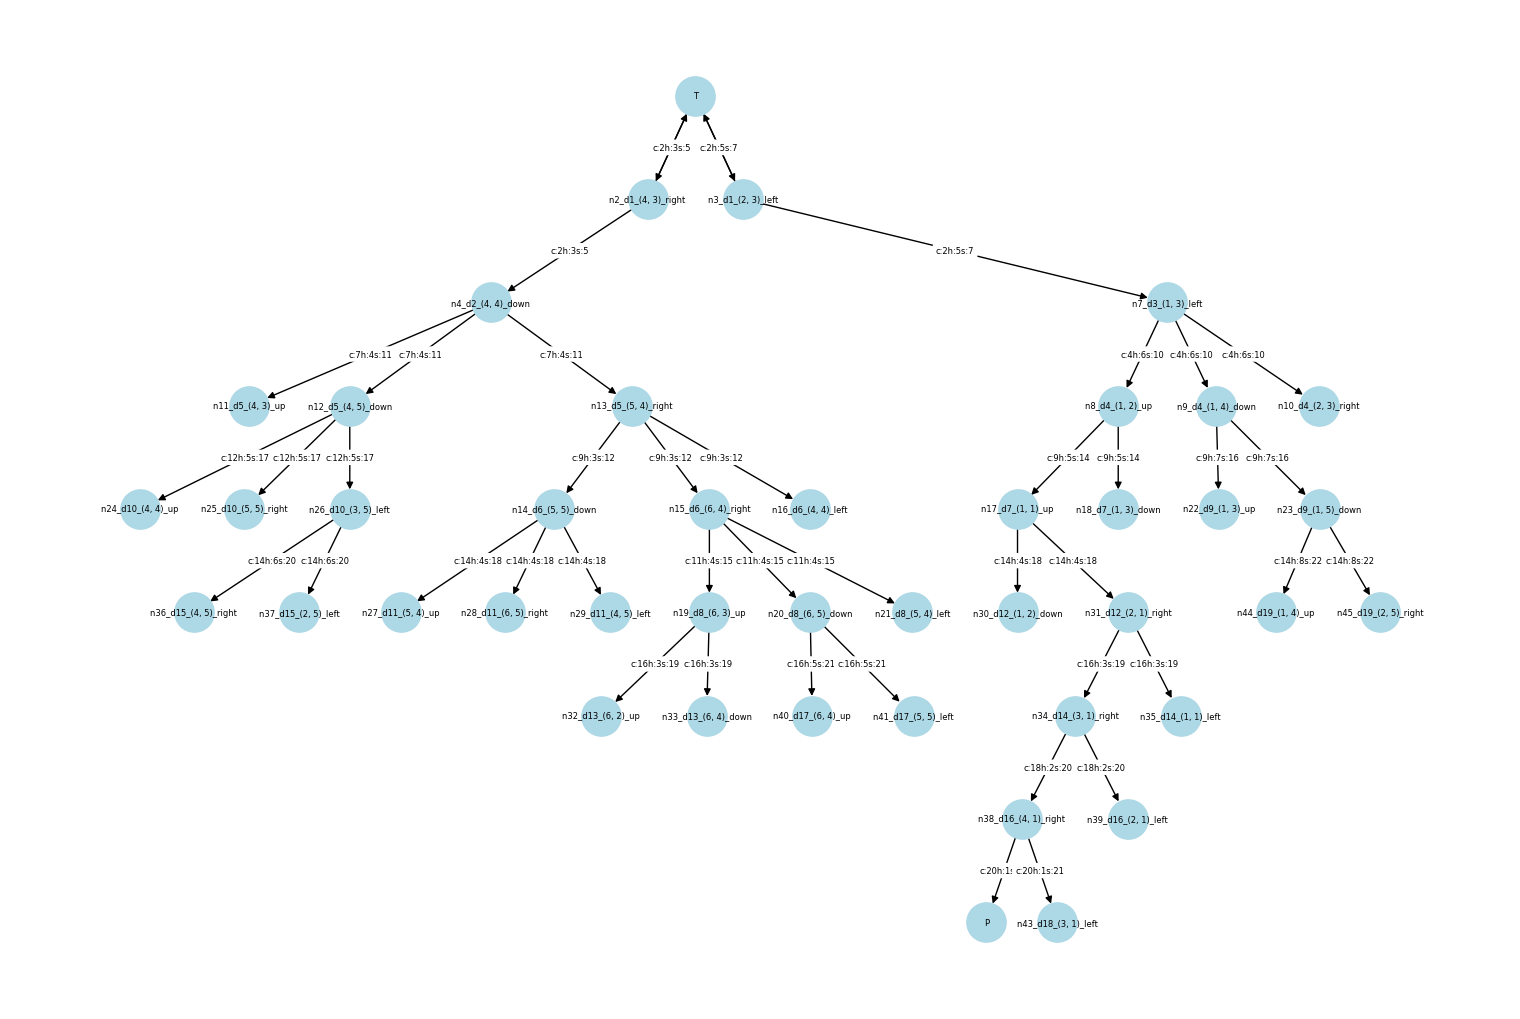

In [120]:
#!/usr/bin/env python
# coding: utf-8

# 2024 Modified by: Alejandro Cervantes
# Configuración y llamada para el caso 2
# Se utiliza el mismo mapa pero se varían los costes

MAP_ASCII = """
########
#    P #
# #### #
#  T # #
# ##   #
#      #
########
"""

COSTS = {
    "up": 5.0,
    "down": 5.0,
    "right": 2.0,
    "left": 2.0,
}

node_count = 0
nodes = []
edges = []
depth_count = 1
label_with_heuristic_number = True

algorithms=(astar,)
main (MAP_ASCII, COSTS, algorithms)

# Crear un grafo tipo árbol
G = nx.DiGraph()

G.add_edges_from(edges)

for edge in edges:
    print(edge)

# Dibujar el grafo con un diseño jerárquico
pos = nx.nx_agraph.graphviz_layout(G, prog="dot")  # Necesita Graphviz instalado
plt.figure(figsize=(15, 10))
nx.draw(G, pos, with_labels=True, arrows=True, node_size=800, node_color="lightblue", font_size=6)

# Get edge labels and draw them
edge_labels = nx.get_edge_attributes(G, "cost")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6, rotate=False)

# Mostrar el árbol
plt.show()

## A* diferentes heurísticas

Experimento con algoritmo <function astar at 0x000001D4AA0FEC00>:
i:T ac:0
New node n2_d1_(4, 3)_right ac -> 1
i:T ac:0
New node n3_d1_(2, 3)_left ac -> 1
i:n2_d1_(4, 3)_right ac:1
New node n4_d2_(4, 4)_down ac -> 2
i:n2_d1_(4, 3)_right ac:1
New node T ac -> 2
i:n3_d1_(2, 3)_left ac:1
New node T ac -> 2
i:n3_d1_(2, 3)_left ac:1
New node n7_d3_(1, 3)_left ac -> 2
i:n4_d2_(4, 4)_down ac:2
New node n8_d4_(4, 3)_up ac -> 3
i:n4_d2_(4, 4)_down ac:2
New node n9_d4_(4, 5)_down ac -> 3
i:n4_d2_(4, 4)_down ac:2
New node n10_d4_(5, 4)_right ac -> 3
i:n10_d4_(5, 4)_right ac:3
New node n11_d5_(5, 5)_down ac -> 4
i:n10_d4_(5, 4)_right ac:3
New node n12_d5_(6, 4)_right ac -> 4
i:n10_d4_(5, 4)_right ac:3
New node n13_d5_(4, 4)_left ac -> 4
i:n9_d4_(4, 5)_down ac:3
New node n14_d6_(4, 4)_up ac -> 4
i:n9_d4_(4, 5)_down ac:3
New node n15_d6_(5, 5)_right ac -> 4
i:n9_d4_(4, 5)_down ac:3
New node n16_d6_(3, 5)_left ac -> 4
i:n11_d5_(5, 5)_down ac:4
i:n15_d6_(5, 5)_right ac:4
New node n17_d7_(5, 4)_up ac -

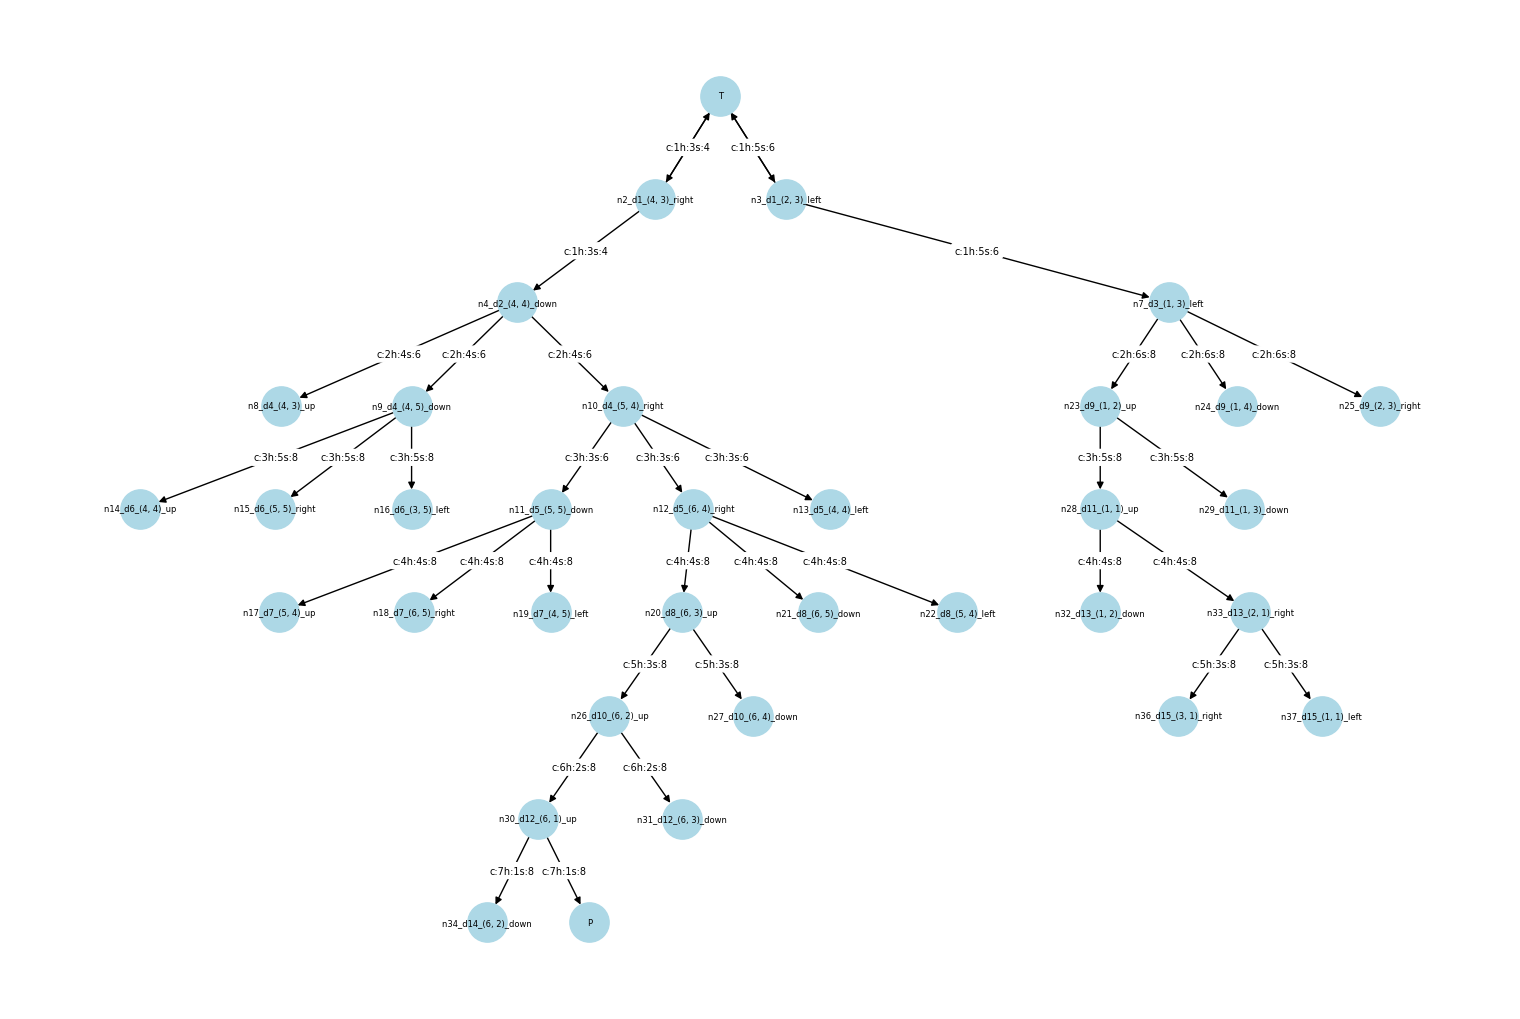

In [121]:
#!/usr/bin/env python
# coding: utf-8

# 2024 Modified by: Alejandro Cervantes
# Configuración y llamada para el caso 3
# Se utiliza el mismo mapa y se usan diferentes heurísticas

MAP_ASCII = """
########
#    P #
# #### #
#  T # #
# ##   #
#      #
########
"""

COSTS = {
    "up": 1.0,
    "down": 1.0,
    "right": 1.0,
    "left": 1.0,
}

node_count = 0
nodes = []
edges = []
depth_count = 1
label_with_heuristic_number = True

algorithms=(astar,)
main (MAP_ASCII,COSTS,algorithms,1)

# Crear un grafo tipo árbol
G = nx.DiGraph()

G.add_edges_from(edges)

# for edge in edges:
#     print(edge)

# Dibujar el grafo con un diseño jerárquico
pos = nx.nx_agraph.graphviz_layout(G, prog="dot")  # Necesita Graphviz instalado
plt.figure(figsize=(15, 10))
nx.draw(G, pos, with_labels=True, arrows=True, node_size=800, node_color="lightblue", font_size=6)

# Get edge labels and draw them
edge_labels = nx.get_edge_attributes(G, "cost")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, rotate=False)

# Mostrar el árbol
plt.show()

Experimento con algoritmo <function astar at 0x000001D4AA0FEC00>:
i:T ac:0
New node n2_d1_(4, 3)_right ac -> 1
i:T ac:0
New node n3_d1_(2, 3)_left ac -> 1
i:n2_d1_(4, 3)_right ac:1
New node n4_d2_(4, 4)_down ac -> 2
i:n2_d1_(4, 3)_right ac:1
New node T ac -> 2
i:n3_d1_(2, 3)_left ac:1
New node T ac -> 2
i:n3_d1_(2, 3)_left ac:1
New node n7_d3_(1, 3)_left ac -> 2
i:n4_d2_(4, 4)_down ac:2
New node n8_d4_(4, 3)_up ac -> 3
i:n4_d2_(4, 4)_down ac:2
New node n9_d4_(4, 5)_down ac -> 3
i:n4_d2_(4, 4)_down ac:2
New node n10_d4_(5, 4)_right ac -> 3
i:n7_d3_(1, 3)_left ac:2
New node n11_d5_(1, 2)_up ac -> 3
i:n7_d3_(1, 3)_left ac:2
New node n12_d5_(1, 4)_down ac -> 3
i:n7_d3_(1, 3)_left ac:2
New node n13_d5_(2, 3)_right ac -> 3
i:n10_d4_(5, 4)_right ac:3
New node n14_d6_(5, 5)_down ac -> 4
i:n10_d4_(5, 4)_right ac:3
New node n15_d6_(6, 4)_right ac -> 4
i:n10_d4_(5, 4)_right ac:3
New node n16_d6_(4, 4)_left ac -> 4
i:n11_d5_(1, 2)_up ac:3
New node n17_d7_(1, 1)_up ac -> 4
i:n11_d5_(1, 2)_up ac:3
N

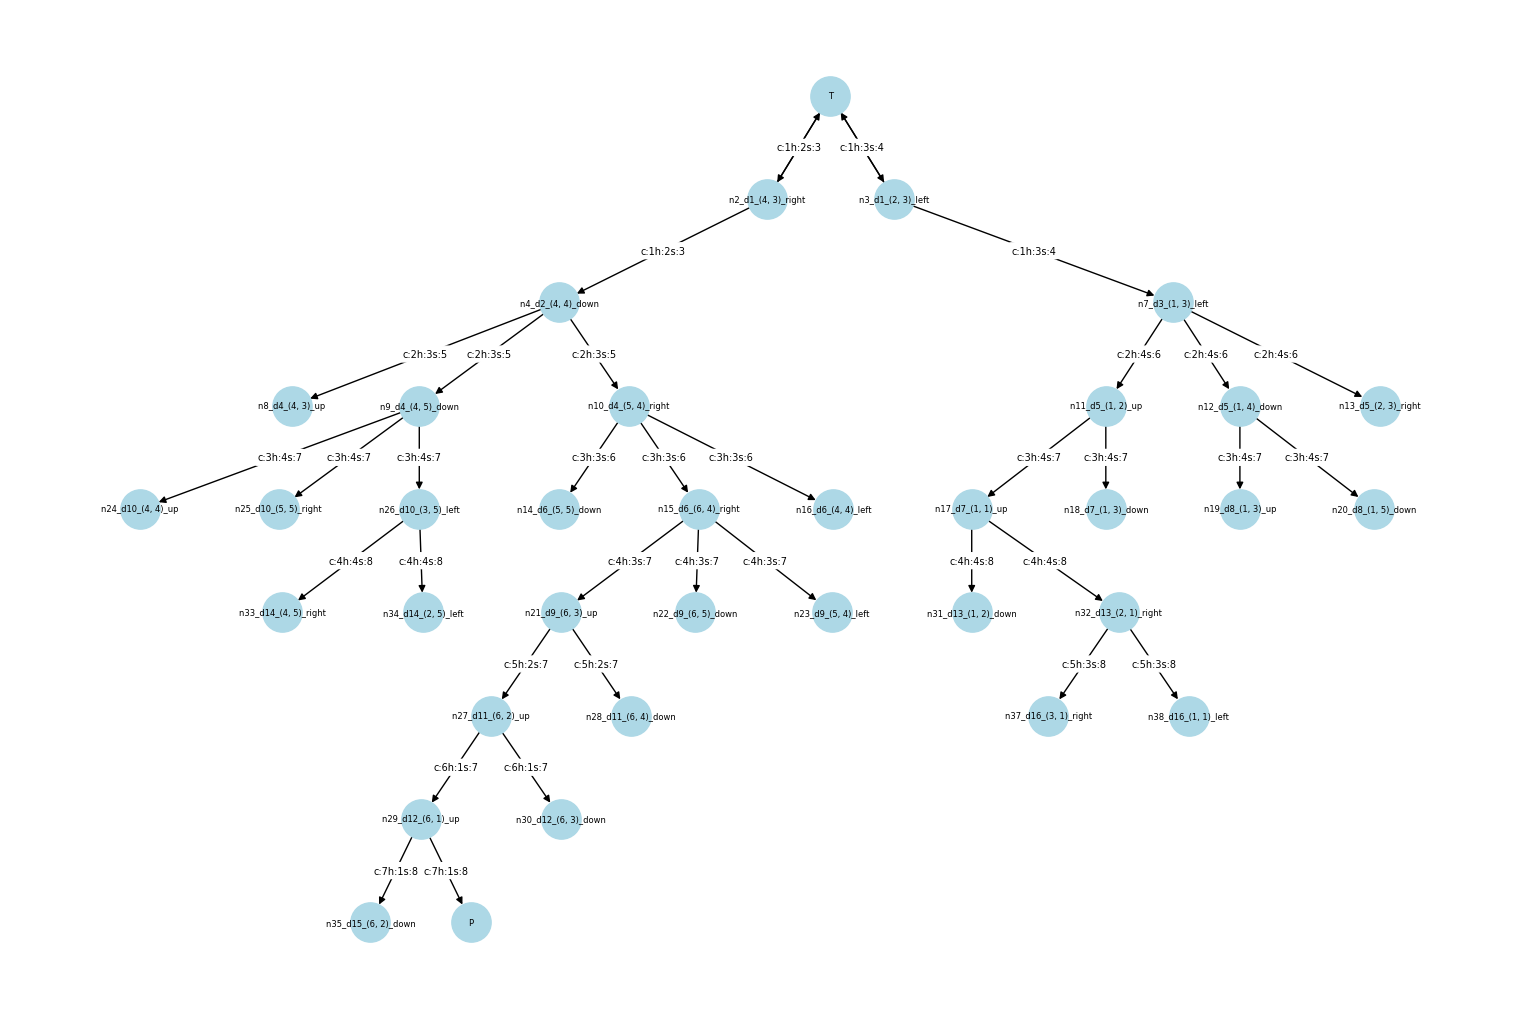

In [122]:
node_count = 0
nodes = []
edges = []
depth_count = 1
label_with_heuristic_number = True

main (MAP_ASCII,COSTS,algorithms,2)

# Crear un grafo tipo árbol
G = nx.DiGraph()

G.add_edges_from(edges)

# for edge in edges:
#     print(edge)

# Dibujar el grafo con un diseño jerárquico
pos = nx.nx_agraph.graphviz_layout(G, prog="dot")  # Necesita Graphviz instalado
plt.figure(figsize=(15, 10))
nx.draw(G, pos, with_labels=True, arrows=True, node_size=800, node_color="lightblue", font_size=6)

# Get edge labels and draw them
edge_labels = nx.get_edge_attributes(G, "cost")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, rotate=False)

# Mostrar el árbol
plt.show()

Experimento con algoritmo <function astar at 0x000001D4AA0FEC00>:
i:T ac:0
New node n2_d1_(4, 3)_right ac -> 1
i:T ac:0
New node n3_d1_(2, 3)_left ac -> 1
i:n2_d1_(4, 3)_right ac:1
New node n4_d2_(4, 4)_down ac -> 2
i:n2_d1_(4, 3)_right ac:1
New node T ac -> 2
i:n4_d2_(4, 4)_down ac:2
New node n6_d3_(4, 3)_up ac -> 3
i:n4_d2_(4, 4)_down ac:2
New node n7_d3_(4, 5)_down ac -> 3
i:n4_d2_(4, 4)_down ac:2
New node n8_d3_(5, 4)_right ac -> 3
i:n8_d3_(5, 4)_right ac:3
New node n9_d4_(5, 5)_down ac -> 4
i:n8_d3_(5, 4)_right ac:3
New node n10_d4_(6, 4)_right ac -> 4
i:n8_d3_(5, 4)_right ac:3
New node n11_d4_(4, 4)_left ac -> 4
i:n3_d1_(2, 3)_left ac:1
New node T ac -> 2
i:n3_d1_(2, 3)_left ac:1
New node n13_d5_(1, 3)_left ac -> 2
i:n9_d4_(5, 5)_down ac:4
New node n14_d6_(5, 4)_up ac -> 5
i:n9_d4_(5, 5)_down ac:4
New node n15_d6_(6, 5)_right ac -> 5
i:n9_d4_(5, 5)_down ac:4
New node n16_d6_(4, 5)_left ac -> 5
i:n10_d4_(6, 4)_right ac:4
New node n17_d7_(6, 3)_up ac -> 5
i:n10_d4_(6, 4)_right ac:4

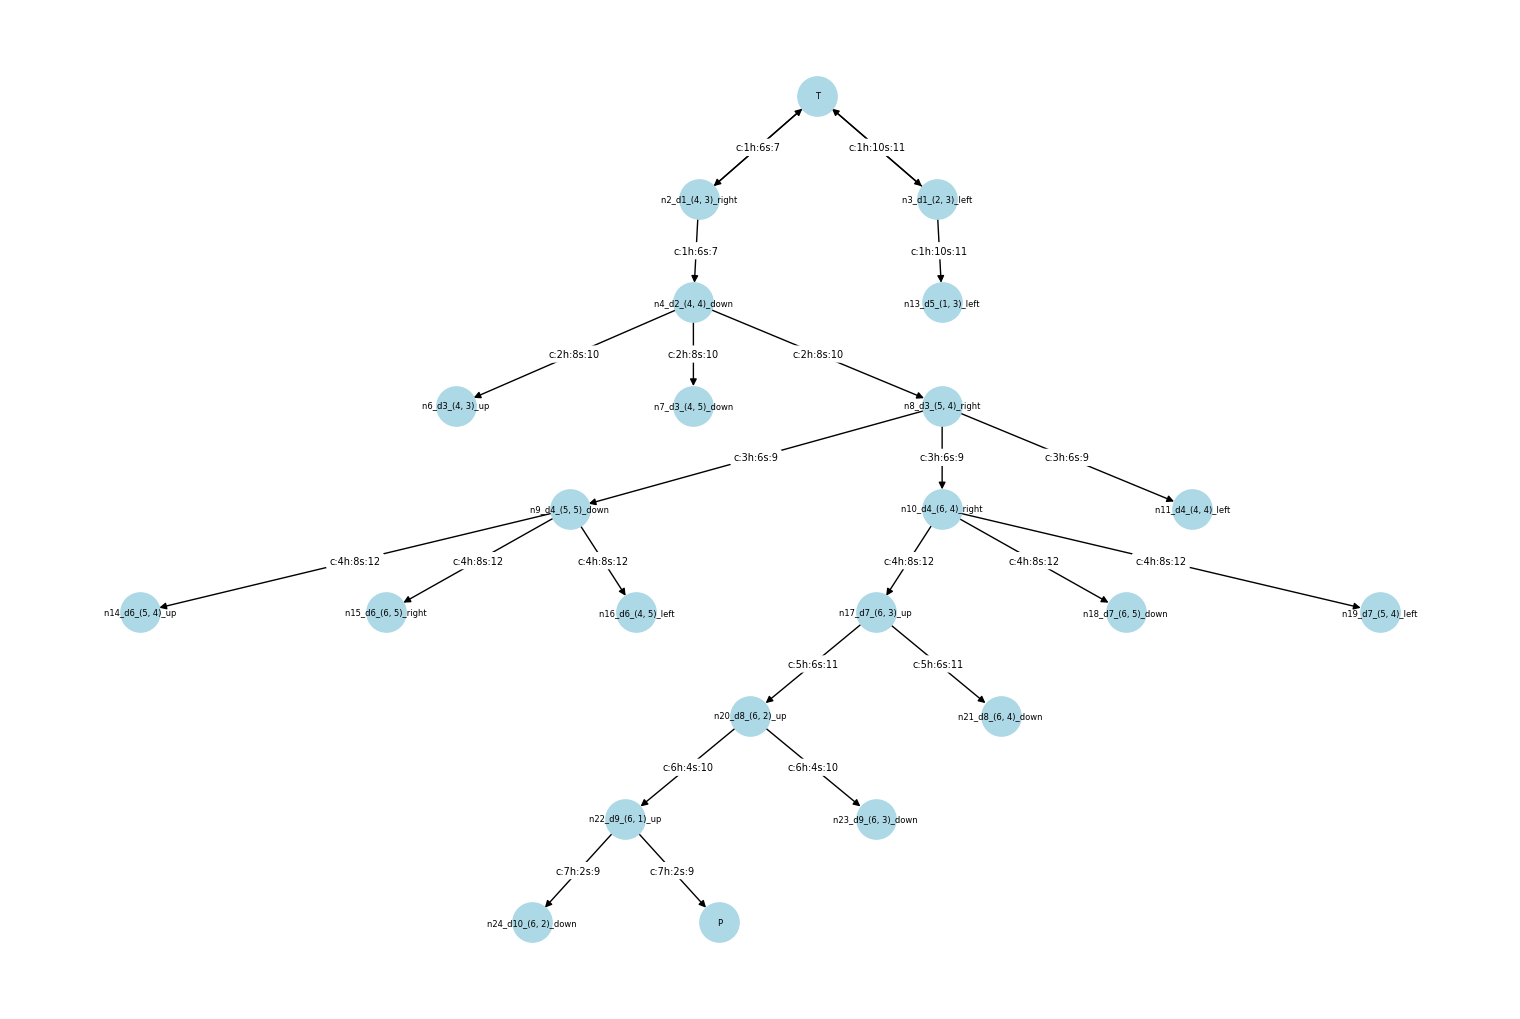

In [123]:
node_count = 0
nodes = []
edges = []
depth_count = 1
label_with_heuristic_number = True

main (MAP_ASCII,COSTS,algorithms,3)

# Crear un grafo tipo árbol
G = nx.DiGraph()

G.add_edges_from(edges)

# for edge in edges:
#     print(edge)

# Dibujar el grafo con un diseño jerárquico
pos = nx.nx_agraph.graphviz_layout(G, prog="dot")  # Necesita Graphviz instalado
plt.figure(figsize=(15, 10))
nx.draw(G, pos, with_labels=True, arrows=True, node_size=800, node_color="lightblue", font_size=6)

# Get edge labels and draw them
edge_labels = nx.get_edge_attributes(G, "cost")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, rotate=False)

# Mostrar el árbol
plt.show()

In [124]:
#!/usr/bin/env python
# coding: utf-8

# 2024 Modified by: Alejandro Cervantes
# Configuración y llamada para el caso 2
# Se utiliza el mismo mapa pero se varían los costes

MAP_ASCII = """
########
#    P #
# #### #
#  T # #
# ##   #
#      #
########
"""


COSTS = {
    "up": 1.0,
    "down": 1.0,
    "right": 1.0,
    "left": 1.0,
}5


node_count = 0
nodes = []
edges = []
depth_count = 1
label_with_heuristic_number = False

algorithms=(uniform_cost,)
main (MAP_ASCII, COSTS, algorithms)

# Crear un grafo tipo árbol
G = nx.DiGraph()

G.add_edges_from(edges)

# for edge in edges:
#     print(edge)

# Dibujar el grafo con un diseño jerárquico
pos = nx.nx_agraph.graphviz_layout(G, prog="dot")  # Necesita Graphviz instalado
plt.figure(figsize=(15, 10))
nx.draw(G, pos, with_labels=True, arrows=True, node_size=800, node_color="lightblue", font_size=6)

# Get edge labels and draw them
edge_labels = nx.get_edge_attributes(G, "cost")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, rotate=False)

# Mostrar el árbol
plt.show()

SyntaxError: invalid syntax (425157169.py, line 24)